## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import numpy as np

In [2]:
import pandas as pd

# Setting seed & importing data

In [3]:
tf.random.set_seed(8)

df = pd.read_csv('data/original_data.csv')
df.head()

,headline,label
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
df.isna().sum()

headline    0
label       0
dtype: int64

In [5]:
df.shape

(26709, 2)

## Splitting data

In [6]:
X = df["headline"]
y = df["label"]

splitting data 70\% train, 10\% validation, 20\% test

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=8)

In [8]:
X_train.sample(4)

1830     on the margins of the margins: refugees with i...
4048     this note left in robert griffin iii's locker ...
12013    james corden's 'melania' longs to be part of o...
15752         5 reasons to love the new york city marathon
Name: headline, dtype: object

## Tokenization and padding

In [9]:
# tokenizing:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# padding:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

max_length = max(len(sequence) for sequence in sequences_train)

padded_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
padded_val = pad_sequences(sequences_val, maxlen=max_length, padding='post')
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')


print(padded_train[0:3])
print(max_length)

[[ 6553  1214  1060  6554  8497  6555     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [   36  1015    27  8498  1215   524 12215   112    51    13    89  1984
    118   293     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [ 1739    13    38     4    86    83    56    15    36    39   711    14
   8499  4017   605    91   174     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
40


## Word2Vec embedding

In [10]:
word_vectors_w2v = KeyedVectors.load_word2vec_format('C:/Users/olivi/Downloads/GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin', binary=True)

In [11]:
vocab_size = len(word_index) + 1
embed_dim_w2v = 300

embed_matrix_w2v = np.zeros((vocab_size, embed_dim_w2v))

for word, i in word_index.items():
    if word in word_vectors_w2v.key_to_index:
        embedding_vector = word_vectors_w2v[word]
        embed_matrix_w2v[i]= embedding_vector


## Model

In [12]:
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embed_dim_w2v, input_length=max_length,
              weights=[embed_matrix_w2v], trainable=False),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           7428900   
                                                                 
 lstm (LSTM)                 (None, 32)                42624     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7471557 (28.50 MB)
Trainable params: 42657 (166.63 KB)
Non-trainable params: 7428900 (28.34 MB)
_________________________________________________________________


## Training

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [14]:
num_epochs = 10

history_lstm = model_lstm.fit(padded_train, y_train, epochs=num_epochs, validation_data=(padded_val, y_val), verbose=2, callbacks=early_stopping)

Epoch 1/10


585/585 - 9s - loss: 0.5222 - accuracy: 0.7405 - val_loss: 0.4829 - val_accuracy: 0.7704 - 9s/epoch - 16ms/step
Epoch 2/10
585/585 - 6s - loss: 0.4157 - accuracy: 0.8138 - val_loss: 0.4120 - val_accuracy: 0.8090 - 6s/epoch - 10ms/step
Epoch 3/10
585/585 - 6s - loss: 0.3714 - accuracy: 0.8385 - val_loss: 0.3771 - val_accuracy: 0.8260 - 6s/epoch - 10ms/step
Epoch 4/10
585/585 - 6s - loss: 0.3336 - accuracy: 0.8563 - val_loss: 0.3801 - val_accuracy: 0.8385 - 6s/epoch - 11ms/step
Epoch 5/10
585/585 - 6s - loss: 0.3026 - accuracy: 0.8730 - val_loss: 0.3731 - val_accuracy: 0.8427 - 6s/epoch - 11ms/step
Epoch 6/10
585/585 - 6s - loss: 0.2778 - accuracy: 0.8876 - val_loss: 0.3729 - val_accuracy: 0.8419 - 6s/epoch - 10ms/step
Epoch 7/10
585/585 - 6s - loss: 0.2535 - accuracy: 0.8993 - val_loss: 0.3551 - val_accuracy: 0.8457 - 6s/epoch - 10ms/step
Epoch 8/10
585/585 - 6s - loss: 0.2292 - accuracy: 0.9078 - val_loss: 0.3716 - val_accuracy: 0.8525 - 6s/epoch - 10ms/step
Epoch 9/10
Res

## Plotting curves

In [15]:
def plotCurves(history, model_name):
    results = pd.DataFrame(history.history)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    ax1.plot(results.index, results.loss)
    ax1.plot(results.index, results.val_loss)
    ax1.set_title(model_name)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Binary Crossentropy Loss")
    ax1.legend(["Training Loss", "Validation Loss"])
   


 
    ax2.plot(results.index, results.accuracy)
    ax2.plot(results.index, results.val_accuracy)
    ax2.set_title(model_name)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["Training Accuracy", "Validation Accuracy"])
 

    fig.show()

C:\Users\olivi\AppData\Local\Temp\ipykernel_24880\2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


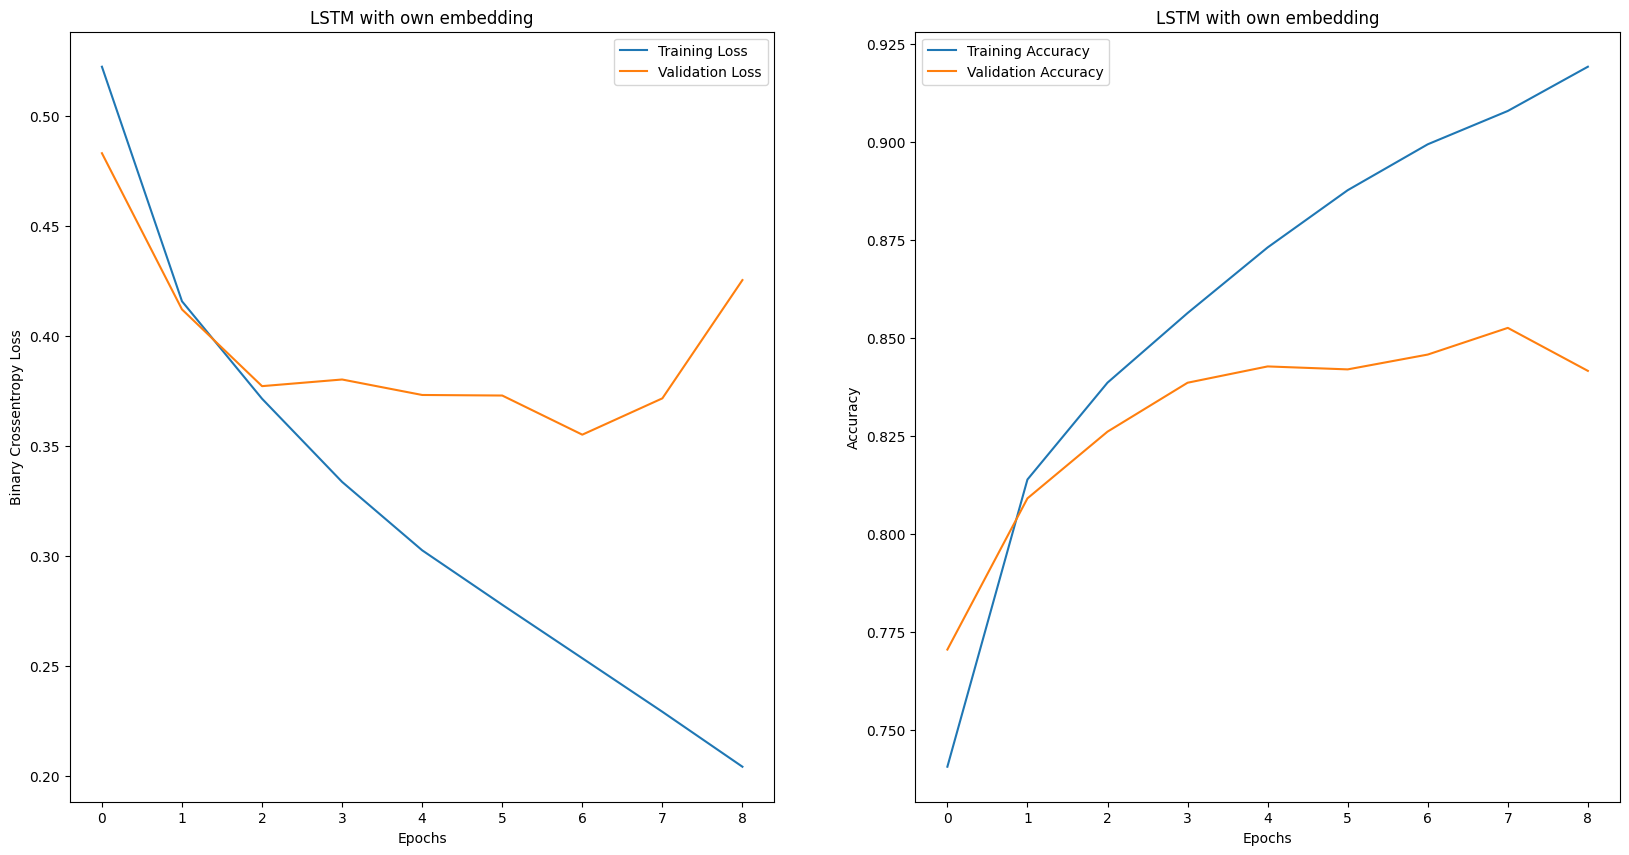

In [16]:
## ReLu with own embedding
plotCurves(history_lstm, "LSTM with own embedding")